# Spark MLlib
## Lab assignment: Example with the MLlib

The aim of this notebook is to play with the MLlib of Apache Spark to create a Machine Learning pipeline that preprocess a dataset, train a model and make predictions. In particular, we are going to deal with a regression problem. The content of this lab has been inspired by the sample provided in the [DataBricks documentation](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2854662143668609/2084788691983918/6837869239396014/latest.html).


## Appliances Energy Prediction

**Data**: This dataset contains Energy consumption from appliances at 10 min resolution for about 4.5 months. The house temperature and humidity conditions were monitored with a wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes. Weather from the nearest airport weather station (Chievres Airport, Belgium) was also logged. This dataset is from [Candanedo et al](http://dx.doi.org/10.1016/j.enbuild.2017.01.083) and is hosted by the UCI Machine Learning Repository. [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction).


**Goal**: We want to learn to predict appliances' energy consumption based on weather information. It would also be nice to know which input features are the most relevant to make predictions.

**Approach**: We will use Spark ML Pipelines, which help users piece together parts of a workflow such as feature processing and model training. We will also demonstrate model selection (a.k.a. hyperparameter tuning) using Cross Validation in order to fine-tune and improve our ML model.

## Submission and marking criteria

You should complete this notebook and add your solutions to it. When you are done, rename your completed notebook as `ex04.ipynb`. 

Important notes:
- The **group leader** must submit the `ex04.ipynb` file on Moodle.
- **Each member of the group** must complete the peer review survey and their contribution statement using this [link](https://forms.office.com/Pages/ResponsePage.aspx?id=7qe9Z4D970GskTWEGCkKHjZupmfSK6JKqlvGZrucaoBURFJJWllYWVhQS09PMFNBVzlCT05JUjM4VCQlQCN0PWcu). **You can only submit this survey ONCE**.
- This lab is marked out of 100 marks, and each section is allocated a number of marks that are indicated below.
- The marking will be focused on the efficiency of the solution and its functionality. Minor mistakes will deduct marks from each exercise.

- **Submission deadline: 8th April 2024 at 3pm**

The first thing we need to do to start working with Spark is to initialize the `SparkSession`. We will also import a few libraries we will use. *Remember if you are using Databricks that `spark` and `sc` are already available to you and don't need initializing.* 

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MLlib lab") \
    .getOrCreate()

sc = spark.sparkContext

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import Row

# Helper function to test the correctness of the solutions
def test(var, val, msg=""):
    print("1 test passed.") if var == val else print("1 test failed. " + msg)

## Load and understand the data  [10 marks]

We begin by loading the data, which is in Comma-Separated Value (CSV) format. For that, you should use `spark.read` to read the file. Then, you should also cache the data so that we only read it from disk once.

In [3]:
# <FILL-IN WITH YOUR CODE>
df = spark.read.csv("data/energydata_complete.csv", header=True, inferSchema=True)
# Cache your DataFrame
df.cache()
# <FILL-IN WITH YOUR CODE>


DataFrame[date: timestamp, Appliances: double, lights: double, T1: double, RH_1: double, T2: double, RH_2: double, T3: double, RH_3: double, T4: double, RH_4: double, T5: double, RH_5: double, T6: double, RH_6: double, T7: double, RH_7: double, T8: double, RH_8: double, T9: double, RH_9: double, T_out: double, Press_mm_hg: double, RH_out: double, Windspeed: double, Visibility: double, Tdewpoint: double, rv1: double, rv2: double]

In [4]:
test(df.count(), 19735, 'Incorrect number of rows')
test(df.is_cached, True, 'df not cached')

1 test passed.
1 test passed.


#### Data description

From the UCI ML Repository description, we know that the columns have the following meanings.

**Attribute information**:
```
date time year-month-day hour:minute:second
Appliances, energy use in Wh
lights, energy use of light fixtures in the house in Wh
T1, Temperature in kitchen area, in Celsius
RH_1, Humidity in kitchen area, in %
T2, Temperature in living room area, in Celsius
RH_2, Humidity in living room area, in %
T3, Temperature in laundry room area
RH_3, Humidity in laundry room area, in %
T4, Temperature in office room, in Celsius
RH_4, Humidity in office room, in %
T5, Temperature in bathroom, in Celsius
RH_5, Humidity in bathroom, in %
T6, Temperature outside the building (north side), in Celsius
RH_6, Humidity outside the building (north side), in %
T7, Temperature in ironing room , in Celsius
RH_7, Humidity in ironing room, in %
T8, Temperature in teenager room 2, in Celsius
RH_8, Humidity in teenager room 2, in %
T9, Temperature in parents room, in Celsius
RH_9, Humidity in parents room, in %
To, Temperature outside (from Chievres weather station), in Celsius
Pressure (from Chievres weather station), in mm Hg
RH_out, Humidity outside (from Chievres weather station), in %
Wind speed (from Chievres weather station), in m/s
Visibility (from Chievres weather station), in km
Tdewpoint (from Chievres weather station), Â°C
rv1, Random variable 1, nondimensional
rv2, Random variable 2, nondimensional
```

**The target variable is the energy use of the Appliances.**

For now, we will leave the two variables `rv1` and `rv2` in our dataset, to see if they are affecting much our methods, then we can try to remove them and see if we improve the results.

Use `show` to visualise the data. Be careful not to show the entire data frame :-), only 5 rows!

In [5]:
# <FILL-IN WITH YOUR CODE>
df.show(5)

+-------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+----------------+-----+----------------+----------------+----------------+----------------+----+----------------+----------------+-----+----------------+-----------+------+----------------+----------------+---------+------------------+------------------+
|               date|Appliances|lights|   T1|            RH_1|  T2|            RH_2|   T3|            RH_3|              T4|            RH_4|              T5| RH_5|              T6|            RH_6|              T7|            RH_7|  T8|            RH_8|              T9| RH_9|           T_out|Press_mm_hg|RH_out|       Windspeed|      Visibility|Tdewpoint|               rv1|               rv2|
+-------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+----------------+-----+----------------+----------------+----------

# Data preprocessing [10 marks]

This dataset is nicely prepared for Machine Learning and required very little preprocessing. However, rather than keeping the date as a timestamp, we would like to have some additional columns, including 'day of the year', 'hour', and 'month of the year'. Please use the naming `dayofyear`, `hour` and `month`, respectively.

**Hint**: Of course the SparkSQL library has a function to transform strings with datetime!

Would you like to have any other information from the datetime? Feel free to add other features.

In [6]:
# <FILL-IN WITH YOUR CODE>
from pyspark.sql.functions import col, dayofyear, hour, month, to_timestamp
df = df.withColumn("date", to_timestamp(col("date")))
df = df.withColumn("dayofyear", dayofyear("date"))
df = df.withColumn("hour", hour("date"))
df = df.withColumn("month", month("date"))
df.show(5)

+-------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+----------------+-----+----------------+----------------+----------------+----------------+----+----------------+----------------+-----+----------------+-----------+------+----------------+----------------+---------+------------------+------------------+---------+----+-----+
|               date|Appliances|lights|   T1|            RH_1|  T2|            RH_2|   T3|            RH_3|              T4|            RH_4|              T5| RH_5|              T6|            RH_6|              T7|            RH_7|  T8|            RH_8|              T9| RH_9|           T_out|Press_mm_hg|RH_out|       Windspeed|      Visibility|Tdewpoint|               rv1|               rv2|dayofyear|hour|month|
+-------------------+----------+------+-----+----------------+----+----------------+-----+----------------+----------------+----------------+----------------+-----+--

When you dataframe `df` has the additional columns, please remove the column `date`:

In [7]:
# <FILL-IN WITH YOUR CODE>
df = df.drop("date")

In [8]:
test("date" in df.columns, False, "Column date has not been remove!")
test("hour" in df.columns, True, "The hour hasn't been added")
test("dayofyear" in df.columns, True, "The dayofyear hasn't been added")
test("month" in df.columns, True, "The month hasn't been added")

1 test passed.
1 test passed.
1 test passed.
1 test passed.


Check the schema of your dataframe:

In [9]:
# <FILL-IN WITH YOUR CODE>
df.printSchema()

root
 |-- Appliances: double (nullable = true)
 |-- lights: double (nullable = true)
 |-- T1: double (nullable = true)
 |-- RH_1: double (nullable = true)
 |-- T2: double (nullable = true)
 |-- RH_2: double (nullable = true)
 |-- T3: double (nullable = true)
 |-- RH_3: double (nullable = true)
 |-- T4: double (nullable = true)
 |-- RH_4: double (nullable = true)
 |-- T5: double (nullable = true)
 |-- RH_5: double (nullable = true)
 |-- T6: double (nullable = true)
 |-- RH_6: double (nullable = true)
 |-- T7: double (nullable = true)
 |-- RH_7: double (nullable = true)
 |-- T8: double (nullable = true)
 |-- RH_8: double (nullable = true)
 |-- T9: double (nullable = true)
 |-- RH_9: double (nullable = true)
 |-- T_out: double (nullable = true)
 |-- Press_mm_hg: double (nullable = true)
 |-- RH_out: double (nullable = true)
 |-- Windspeed: double (nullable = true)
 |-- Visibility: double (nullable = true)
 |-- Tdewpoint: double (nullable = true)
 |-- rv1: double (nullable = true)
 |-- rv2

Dammit, all the input features have been inferred as strings rather than numeric values. This is because we read the data from a CSV file with the data in between quotes.

Your task now is to transform that into numerical values. All of the features are actually numeric, so you could cast all of them. You are recommended to use functions like `cast` and `col` to do this. You could try to leave out the datetime columns we created, but it's fine if you transform them to float.

In [10]:
# <FILL-IN WITH YOUR CODE>
exclude_cols = ["day", "month", "year", "dayofyear", "hour"]
cols_to_cast = [col_name for col_name in df.columns if col_name not in exclude_cols]
for col_name in cols_to_cast:
    df = df.withColumn(col_name, col(col_name).cast("float"))

In [11]:
#print the schema again.
# <FILL-IN WITH YOUR CODE>
df.printSchema()

root
 |-- Appliances: float (nullable = true)
 |-- lights: float (nullable = true)
 |-- T1: float (nullable = true)
 |-- RH_1: float (nullable = true)
 |-- T2: float (nullable = true)
 |-- RH_2: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- RH_3: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- RH_4: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- RH_5: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- RH_6: float (nullable = true)
 |-- T7: float (nullable = true)
 |-- RH_7: float (nullable = true)
 |-- T8: float (nullable = true)
 |-- RH_8: float (nullable = true)
 |-- T9: float (nullable = true)
 |-- RH_9: float (nullable = true)
 |-- T_out: float (nullable = true)
 |-- Press_mm_hg: float (nullable = true)
 |-- RH_out: float (nullable = true)
 |-- Windspeed: float (nullable = true)
 |-- Visibility: float (nullable = true)
 |-- Tdewpoint: float (nullable = true)
 |-- rv1: float (nullable = true)
 |-- rv2: float (nullable = true)
 

## Split data into training and test sets [10 marks]

Our final data preparation step is to split our dataset into training and test sets. We will train and tune our model on the training set, and then see how well we do in the test.

Your task is to split the dataframe `df` into 70% for training and 30% for test. Please use the same random seed.

In [12]:
# <FILL-IN WITH YOUR CODE>
seed = 654321
train_df, test_df = df.randomSplit([0.7, 0.3], seed = seed)
print("Number of rows in training set:", train_df.count())
print("Number of rows in test set:", test_df.count())

Number of rows in training set: 13752
Number of rows in test set: 5983


Even though we have fixed the random seed, you will not get the exact same split. 

Note that this is the simplest way of validating your results. You may want to carry out a [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) and split the dataset into *k* folds, and build and test *k* models. We will do later cross validation but for parameter tuning! not to validate our approach!

## Data visualisation [10 marks]

Before applying any machine learning algorithm, it is a good practice to try to visualise your data. For example, we could see how much energy is spent in appliances depending on the month. 

In [13]:
# create a variable `hist_elect` that contains the histogram of total energy consumed by the Appliances, grouped by month
# <FILL-IN WITH YOUR CODE>
hist_elect = df.select('month', 'Appliances').groupBy('month').agg({'Appliances':'sum'}).orderBy('month')
hist_elect.show()
hist_elect = hist_elect.collect()

+-----+---------------+
|month|sum(Appliances)|
+-----+---------------+
|    1|       283510.0|
|    2|       421550.0|
|    3|       432800.0|
|    4|       427200.0|
|    5|       362950.0|
+-----+---------------+



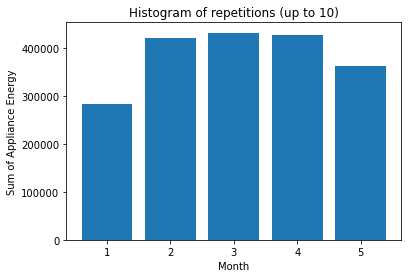

In [14]:
(x_values, y_values) = zip(*hist_elect)
plt.bar(x_values, y_values)
plt.title('Histogram of repetitions (up to 10)')
plt.xlabel('Month')
plt.ylabel('Sum of Appliance Energy')
plt.show()

As we don't seem to have all the data from the 1st of January, well, we have less consumption in that particular months, so probably the month is not a good feature, don't you think? we are going to remove it from the dataframe and the training and test data frames too!

In [15]:
# update the variables `df`, `train` and `test`, removing the column 'month'
# <FILL-IN WITH YOUR CODE>
df = df.drop('month')
train_df = train_df.drop('month')
train_df = test_df.drop('month')
test_df.show(5)

+----------+------+-----+---------+---------+---------+----+-----+-----+---------+---------+---------+----+--------+---------+---------+---------+---------+---------+---------+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-----+
|Appliances|lights|   T1|     RH_1|       T2|     RH_2|  T3| RH_3|   T4|     RH_4|       T5|     RH_5|  T6|    RH_6|       T7|     RH_7|       T8|     RH_8|       T9|     RH_9|   T_out|Press_mm_hg|RH_out|Windspeed|Visibility|Tdewpoint|      rv1|      rv2|dayofyear|hour|month|
+----------+------+-----+---------+---------+---------+----+-----+-----+---------+---------+---------+----+--------+---------+---------+---------+---------+---------+---------+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-----+
|      10.0|   0.0| 18.0|     43.7|17.166666|    44.29|19.1| 42.0|16.89|    44.09|16.688889|    50.28|7.66|83.85667|     17.0|    39.29|17.127777|    45.79|    16.29|   

You could do other plots to understand better the data and practice with Spark :-). This is a good opportunity to practice with the DataFrame API, although if you are running this on Databricks, some plots can be generated very easily by yourself.

In [16]:
# <FILL-IN WITH YOUR CODE>

## Create a Pipeline with Spark ML [20 marks]

As you know, we can't feed the data frame directly to a machine learning algorithm, as we need to put all the input features as an Array, and indicate which one is the output feature (in our case, the 'Appliances' column!).

We will put together a simple Pipeline with the following stages:

- VectorAssembler: To combine all the input columns into a single vector column (i.e. all the columns but the 'Appliances' one.
- Learning algorithm: I feel like using Gradient-Boosted Trees [GBTs](https://en.wikipedia.org/wiki/Gradient_boosting) for this example, but feel free to use anything else.
- CrossValidator: I will use cross validation to tune the parameters of the GBT model. Yes, this can be added as part of a pipeline!  This is going to change the way we access the best model later!  

Step 1: Create the `VectorAssembler`:

In [17]:
from pyspark.ml.feature import VectorAssembler
feature_cols = train_df.columns
feature_cols.remove('Appliances')
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# <FILL-IN WITH YOUR CODE>

In [18]:
assembler.transform(train_df).show(5, truncate=False)

+----------+------+-----+---------+---------+---------+----+-----+-----+---------+---------+---------+----+--------+---------+---------+---------+---------+---------+---------+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Appliances|lights|T1   |RH_1     |T2       |RH_2     |T3  |RH_3 |T4   |RH_4     |T5       |RH_5     |T6  |RH_6    |T7       |RH_7     |T8       |RH_8     |T9       |RH_9     |T_out   |Press_mm_hg|RH_out|Windspeed|Visibility|Tdewpoint|rv1      |rv2      |dayofyear|hour|features 

In [19]:
assembler.transform(train_df).printSchema()

root
 |-- Appliances: float (nullable = true)
 |-- lights: float (nullable = true)
 |-- T1: float (nullable = true)
 |-- RH_1: float (nullable = true)
 |-- T2: float (nullable = true)
 |-- RH_2: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- RH_3: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- RH_4: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- RH_5: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- RH_6: float (nullable = true)
 |-- T7: float (nullable = true)
 |-- RH_7: float (nullable = true)
 |-- T8: float (nullable = true)
 |-- RH_8: float (nullable = true)
 |-- T9: float (nullable = true)
 |-- RH_9: float (nullable = true)
 |-- T_out: float (nullable = true)
 |-- Press_mm_hg: float (nullable = true)
 |-- RH_out: float (nullable = true)
 |-- Windspeed: float (nullable = true)
 |-- Visibility: float (nullable = true)
 |-- Tdewpoint: float (nullable = true)
 |-- rv1: float (nullable = true)
 |-- rv2: float (nullable = true)
 

Step 2: Create an instance of `GBTRegressor` in which you don't indicate any parameters but the class label (i.e. `labelCol`) to 'Appliances'.

In [20]:
from pyspark.ml.regression import GBTRegressor

#name the variable `gbt` 
gbt = GBTRegressor(featuresCol='features', labelCol='Appliances')

# <FILL-IN WITH YOUR CODE>

Step 3: Create a `CrossValidator` for `gbt`.

You can explore the parameters you like for GBT. Full documentation [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html). I would suggest to create a 'grid' for at least the depth of the tree and the number of iterations. Don't investigate more than 4-8 combinations! :-)

Import the right libraries:

In [21]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [22]:
# define a variable `paramGrid` with some parameters, e.g. for maxDepth, range [5,8], and for maxIter [10,20]
paramGrid = ParamGridBuilder()\
            .addGrid(gbt.maxDepth, [3,5,8])\
            .addGrid(gbt.maxIter, [5,10,20])\
            .build()

for params in paramGrid:
    print(params)
# <FILL-IN WITH YOUR CODE>

{Param(parent='GBTRegressor_5342eeeb64fe', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3, Param(parent='GBTRegressor_5342eeeb64fe', name='maxIter', doc='max number of iterations (>= 0).'): 5}
{Param(parent='GBTRegressor_5342eeeb64fe', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3, Param(parent='GBTRegressor_5342eeeb64fe', name='maxIter', doc='max number of iterations (>= 0).'): 10}
{Param(parent='GBTRegressor_5342eeeb64fe', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 3, Param(parent='GBTRegressor_5342eeeb64fe', name='maxIter', doc='max number of iterations (>= 0).'): 20}
{Param(parent='GBTRegressor_5342eeeb64fe', name='maxDepth', do

Create a RegressionEvaluator that uses the [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) as our performance metric. Import the right package first:

In [23]:
from pyspark.ml.evaluation import RegressionEvaluator

In [24]:
# create a variable `evaluator` with a rmse as metric for the prediction column given by `gbt`.
evaluator = RegressionEvaluator(metricName='mae', labelCol='Appliances', predictionCol='prediction')
# <FILL-IN WITH YOUR CODE>

We can now create a CrossValidator `cv` that uses the `gbt` as estimator, as well as the evaluator and grid we defined above.

In [25]:
# <FILL-IN WITH YOUR CODE>
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

Step 4. Create a Pipeline (`pipeline`) that contains the two stages: `vectorAssembler` and `cv`

In [26]:
from pyspark.ml import Pipeline
pipline = Pipeline(stages=[assembler, cv])
# <FILL-IN WITH YOUR CODE>

Step 5. Finally, `fit` the model, and store in a `pipelineModel` variable. This might take quite a bit of time!

In [27]:
# <FILL-IN WITH YOUR CODE>
pipline_model = pipline.fit(train_df)

It could be a good idea to save this to disk, in case it takes too long, so we can read it later.

In [28]:
#pipline_model.save("Model-lab4")

## Evaluate the results [10 marks]

To obtain the predictions in the test set, apply the method `transform()` of the trained pipeline on the test DataFrame! This will not apply the cross-validation of course!

In [29]:
# create a variable `predictions`:
predictions = pipline_model.transform(test_df)
# <FILL-IN WITH YOUR CODE>
test_df.show(5)

+----------+------+-----+---------+---------+---------+----+-----+-----+---------+---------+---------+----+--------+---------+---------+---------+---------+---------+---------+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-----+
|Appliances|lights|   T1|     RH_1|       T2|     RH_2|  T3| RH_3|   T4|     RH_4|       T5|     RH_5|  T6|    RH_6|       T7|     RH_7|       T8|     RH_8|       T9|     RH_9|   T_out|Press_mm_hg|RH_out|Windspeed|Visibility|Tdewpoint|      rv1|      rv2|dayofyear|hour|month|
+----------+------+-----+---------+---------+---------+----+-----+-----+---------+---------+---------+----+--------+---------+---------+---------+---------+---------+---------+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-----+
|      10.0|   0.0| 18.0|     43.7|17.166666|    44.29|19.1| 42.0|16.89|    44.09|16.688889|    50.28|7.66|83.85667|     17.0|    39.29|17.127777|    45.79|    16.29|   

It is easier to view the results when we limit the columns displayed to:

- `Appliances`: the consumption of the Appliances in Wh
- `prediction`: our predicted prediction

Find a way to show the output only for these two features (only for the first 5 rows):

In [30]:
# <FILL-IN WITH YOUR CODE>
predictions.select('Appliances', 'prediction').show(5)

+----------+------------------+
|Appliances|        prediction|
+----------+------------------+
|      10.0|  79.2914018219913|
|      10.0| 39.17598969074051|
|      20.0| 90.83193170125831|
|      20.0|34.990365591868496|
|      20.0| 39.26994041230047|
+----------+------------------+
only showing top 5 rows



Are these results any good? Let's compute the RMSE using the evaluator we created before! Store the result in a `rmse` variable.

In [31]:
# <FILL-IN WITH YOUR CODE>
rmse = evaluator.evaluate(predictions)

In [32]:
print(rmse)

41.538888200156606


Seems a bit high?  Well, this number is closer to what it is reported in the original paper with RF (RMSE around 69).

But maybe you can investigate a bit more if you can improve that. Can you find out the importance of the features from the GBTs?  

You first need to find out the best model!! In the way we trained the pipeline, you can find the trained cvModel as one of the stages of the `pipelineModel`:

In [33]:
cvModel = pipline_model.stages[1]

In [34]:
cvModel.bestModel

GBTRegressionModel: uid=GBTRegressor_5342eeeb64fe, numTrees=20, numFeatures=29

Check the feature importances of that `cvModel`:

In [35]:
cvModel.bestModel.featureImportances

SparseVector(29, {0: 0.041, 1: 0.028, 2: 0.0466, 3: 0.0335, 4: 0.0532, 5: 0.0625, 6: 0.0615, 7: 0.0333, 8: 0.0401, 9: 0.038, 10: 0.0253, 11: 0.0404, 12: 0.0465, 13: 0.0316, 14: 0.0177, 15: 0.0374, 16: 0.0253, 17: 0.0075, 18: 0.0142, 19: 0.0221, 20: 0.0403, 21: 0.036, 22: 0.0402, 23: 0.0157, 24: 0.0315, 25: 0.0195, 27: 0.0137, 28: 0.0974})

Uhm, looks like our model gave feature #28 quite a bit of importance, which is the hour of the day if I recall correctly.  Features #25 and #26 were random, and the model noticed that 26 was completely useless, but gave some importance to 'rv1'. GBTs perform somehow an implicit feature selection, so those low importance features won't affect much their performance, but I wonder if we could just remove low importance features?

*Task*: Create a list of those features with less than for example 0.05. 

In [36]:
pairs = cvModel.bestModel.featureImportances
print(pairs)

(29,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,27,28],[0.04097247955342678,0.02796088866103442,0.04663467602547514,0.03352834982561123,0.053241313012667074,0.062478790166915744,0.06145094779844561,0.033266523501396805,0.040072478930092595,0.03796303438183131,0.025287876826011815,0.04044237183263133,0.04648017324505158,0.03161090450567628,0.017694997546048204,0.037362434292521826,0.02532980931242519,0.007453742436310882,0.014168577233315972,0.02211966754610988,0.04034131192874055,0.03604016599152696,0.04024815831825427,0.015653405159860717,0.0315042113985211,0.019545504950565413,0.013739226019771391,0.09740797959975989])


In [37]:
# create a list `to_remove` that contains the feature names that must be removed because their confidence is less than 0.05 
# <FILL-IN WITH YOUR CODE>
to_remove = []
feature_names = [col for col in df.columns if col != 'Appliances']

for indices, values in enumerate(pairs.values):
    # if importances less than 0.05，append its name to the list
    if values < 0.05:
        to_remove.append(feature_names[indices])
        # to_remove.append(indices)

In [38]:
print(to_remove)

['lights', 'T1', 'RH_1', 'T2', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2']


## Removing low importance features [10 marks]

Check the current schema of the training data:

In [39]:
# <FILL-IN WITH YOUR CODE>
train_df.printSchema()

root
 |-- Appliances: float (nullable = true)
 |-- lights: float (nullable = true)
 |-- T1: float (nullable = true)
 |-- RH_1: float (nullable = true)
 |-- T2: float (nullable = true)
 |-- RH_2: float (nullable = true)
 |-- T3: float (nullable = true)
 |-- RH_3: float (nullable = true)
 |-- T4: float (nullable = true)
 |-- RH_4: float (nullable = true)
 |-- T5: float (nullable = true)
 |-- RH_5: float (nullable = true)
 |-- T6: float (nullable = true)
 |-- RH_6: float (nullable = true)
 |-- T7: float (nullable = true)
 |-- RH_7: float (nullable = true)
 |-- T8: float (nullable = true)
 |-- RH_8: float (nullable = true)
 |-- T9: float (nullable = true)
 |-- RH_9: float (nullable = true)
 |-- T_out: float (nullable = true)
 |-- Press_mm_hg: float (nullable = true)
 |-- RH_out: float (nullable = true)
 |-- Windspeed: float (nullable = true)
 |-- Visibility: float (nullable = true)
 |-- Tdewpoint: float (nullable = true)
 |-- rv1: float (nullable = true)
 |-- rv2: float (nullable = true)
 

You don't need to remove the columns from train and test partitions as you won't be able to re-train the pipeline without modifying the VectorAssemble. You simply need to indicate the columns you want to use when creating a new `vectorAssembler2`:

In [40]:
# <FILL-IN WITH YOUR CODE>
feature_cols = [col for col in df.columns if col != 'Appliances' and col not in to_remove]
assembler2 = VectorAssembler(inputCols=feature_cols, outputCol='features')
print(feature_cols)

['RH_2', 'T3', 'RH_3', 'dayofyear', 'hour']


and create a new pipeline, `pipeline2`, with that new `vectorAssemble2`: 

In [41]:
# <FILL-IN WITH YOUR CODE>
pipline2 = Pipeline(stages=[assembler2, cv])

And `fit` the new pipeline:

In [42]:
# <FILL-IN WITH YOUR CODE>
pipline_model2 = pipline2.fit(train_df)

Finally, make predictions and compute the error:

In [43]:
# <FILL-IN WITH YOUR CODE>
predictions2 = pipline_model2.transform(test_df)
predictions2.select('Appliances', 'prediction').show(5)
rmse2 = evaluator.evaluate(predictions2)

+----------+------------------+
|Appliances|        prediction|
+----------+------------------+
|      10.0|51.226135393876376|
|      10.0|58.668897768214926|
|      20.0|  87.8012489999656|
|      20.0|49.370262243552155|
|      20.0|20.351317060547455|
+----------+------------------+
only showing top 5 rows



In [44]:
print(rmse2)

28.97002156759338


Check the features of the best model and feature importances:

In [45]:
cvModel2 = pipline_model2.stages[1]

In [46]:
cvModel2.bestModel# 

GBTRegressionModel: uid=GBTRegressor_5342eeeb64fe, numTrees=20, numFeatures=5

In [47]:
cvModel2.bestModel.featureImportances

SparseVector(5, {0: 0.2038, 1: 0.2506, 2: 0.19, 3: 0.1614, 4: 0.1942})

In my case, I got the same performance as before, but this time my model only considered 3 input features! This might not have made our model more precise (Because GBTs already ignored those features), but makes it more interpretable!

# Improving further your model [20 marks]

There might be many ways to improve the results we obtained here. 

A few ideas for you to think about:

- Parameter tuning: I have used a relatively small set of parameters, and I haven't investigated what happened in training and test, is there overfitting of the training? would we be able to use a large number of trees?
- The features of this dataset are numerical, are there other classifiers that may be more appropriate than GBTs?
- We haven't really done any careful pre-processing of the data. Are there outliers or noise that might be having an impact in the results? 
- Do we need any normalisation?

In [48]:
df.columns

['Appliances',
 'lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'rv1',
 'rv2',
 'dayofyear',
 'hour']

In [105]:
feature_vectors = assembler2.transform(df)
feature_vectors.show(5, truncate = False)

+----------+------+-----+---------+----+---------+-----+---------+---------+---------+---------+-----+---------+--------+---------+---------+----+---------+---------+-----+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-------------------------------------------------------------------+
|Appliances|lights|T1   |RH_1     |T2  |RH_2     |T3   |RH_3     |T4       |RH_4     |T5       |RH_5 |T6       |RH_6    |T7       |RH_7     |T8  |RH_8     |T9       |RH_9 |T_out   |Press_mm_hg|RH_out|Windspeed|Visibility|Tdewpoint|rv1      |rv2      |dayofyear|hour|features                                                           |
+----------+------+-----+---------+----+---------+-----+---------+---------+---------+---------+-----+---------+--------+---------+---------+----+---------+---------+-----+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+----------------------------------------------------------------

In [106]:
# <FILL-IN WITH YOUR CODE>
#Creating the correlation matrix
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")
scaler_model = scaler.fit(feature_vectors)
scaled_df = scaler_model.transform(feature_vectors)
scaled_df.show(5, truncate = False)

+----------+------+-----+---------+----+---------+-----+---------+---------+---------+---------+-----+---------+--------+---------+---------+----+---------+---------+-----+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-------------------------------------------------------------------+---------------------------------------------------------------------------------+
|Appliances|lights|T1   |RH_1     |T2  |RH_2     |T3   |RH_3     |T4       |RH_4     |T5       |RH_5 |T6       |RH_6    |T7       |RH_7     |T8  |RH_8     |T9       |RH_9 |T_out   |Press_mm_hg|RH_out|Windspeed|Visibility|Tdewpoint|rv1      |rv2      |dayofyear|hour|features                                                           |scaled_features                                                                  |
+----------+------+-----+---------+----+---------+-----+---------+---------+---------+---------+-----+---------+--------+---------+---------+----+---------+---------+

In [107]:
from pyspark.ml.feature import PCA

K = 5 #Number of principal components to retain
pca = PCA(k = K, inputCol = "scaled_features", outputCol = "pca_features")
pca_model = pca.fit(scaled_df)
pca_data = pca_model.transform(scaled_df)
print(pca_model.explainedVariance)

[0.4477038437508238,0.3831446727765937,0.13041124242018573,0.02641785787102675,0.012322383181370038]


In [108]:
pca_data.show(5, truncate = False)

+----------+------+-----+---------+----+---------+-----+---------+---------+---------+---------+-----+---------+--------+---------+---------+----+---------+---------+-----+--------+-----------+------+---------+----------+---------+---------+---------+---------+----+-------------------------------------------------------------------+---------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+
|Appliances|lights|T1   |RH_1     |T2  |RH_2     |T3   |RH_3     |T4       |RH_4     |T5       |RH_5 |T6       |RH_6    |T7       |RH_7     |T8  |RH_8     |T9       |RH_9 |T_out   |Press_mm_hg|RH_out|Windspeed|Visibility|Tdewpoint|rv1      |rv2      |dayofyear|hour|features                                                           |scaled_features                                                                  |pca_features                                                    

In [109]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol = "Appliances", featuresCol = "pca_features")

In [115]:
paramGrid3 = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 50]) \
    .addGrid(rf.maxDepth, [5, 25]) \
    .build()

In [111]:
evaluator3 = RegressionEvaluator(metricName='mae', labelCol='Appliances', predictionCol='prediction')

In [116]:
cv3 = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid3, evaluator=evaluator3, numFolds=10)
pipeline3 = Pipeline(stages=[assembler2, scaler_model, pca_model, cv3])
pipeline_model3 = pipeline3.fit(train_df)

In [117]:
predictions = pipeline_model3.transform(test_df)

In [118]:
predictions.select('Appliances', 'prediction').show(5)

+----------+------------------+
|Appliances|        prediction|
+----------+------------------+
|      10.0| 23.15309523809524|
|      10.0|27.082380952380955|
|      20.0| 51.04395648211438|
|      20.0| 34.64246031746032|
|      20.0| 37.06333333333333|
+----------+------------------+
only showing top 5 rows



In [119]:
rmse = evaluator.evaluate(predictions)

In [120]:
print(rmse)

19.257284453267882
